In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold

## a) load/merge data and visualize logerror

In [2]:
# load data into DataFrames
properties = pd.read_csv('q3_data/properties.csv') 
train = pd.read_csv('q3_data/train.csv') 

data = pd.merge(train,properties,left_on='id',right_on='id',how='left')

In [3]:
# eliminate outliers
min_val = np.percentile(data.logerror, 1)
for i in range(len(data.logerror)):
    if data.logerror[i] < min_val:
        data.logerror[i]= min_val
        
max_val = np.percentile(data.logerror, 99)
for i in range(len(data.logerror)):
    if data.logerror[i] > max_val:
        data.logerror[i]= max_val

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


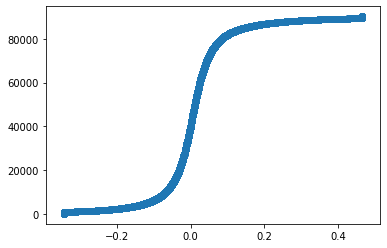

In [4]:
# scatter of logerr
logerr = np.array(data.logerror)
x = np.arange(len(logerr))
plt.scatter(np.sort(logerr),x)
plt.show()

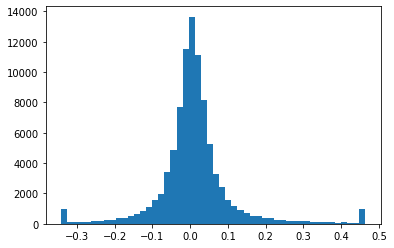

In [5]:
# histogram of logerr
plt.hist(data.logerror, bins = 50)
plt.show()

## b) data cleaning

In [6]:
# build new data frame
column_name = list(data)
missing_count = []
missing_ratio = []

for i in column_name: 
    missing_count.append(data[i].isnull().sum())

missing_ratio = [missing_count[i]/len(data) for i  in range(len(missing_count))]
    
dat_array = np.concatenate(( np.array(column_name).reshape(-1,1),np.array(missing_count).reshape(-1,1),np.array(missing_ratio).reshape(-1,1) ),axis=1)
new_df = pd.DataFrame(dat_array, columns = ['Column Name', 'Missing Count','Missing Ratio' ])

In [7]:
# fill missing data
data = data.fillna(data.mean())

## c) univariate analysis

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


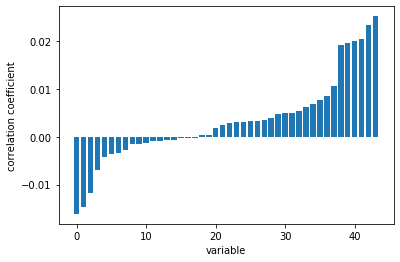

In [8]:
# make bar chart
# For each variable, compute the correlation coefficient with logerror. After that, sort and make a bar chart of these coefficients.
data_num = data.select_dtypes(include=[np.float])
column_name = list(data_num)
covariance = []
for i in column_name:
    C = np.corrcoef(data_num[i], logerr)
    covariance.append( C[0,1] )
y_pos = np.arange(len(column_name)-1)
cov = np.array(covariance)
plt.bar(y_pos,np.sort(cov[1:53:]))
plt.xlabel('variable')
plt.ylabel('correlation coefficient')
plt.show()

# explain reason
There are a few labels without any correlation values because they had mostly NaN values

## d) non-linear regression model

In [9]:
# drop categorical features 
# ("hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag") 
# drop "id" and "transactiondate"
data_num = data.select_dtypes(include=[np.float])

In [12]:
# split and train
dat = data_num.loc[:, data_num.columns != 'logerror']
X_train, X_test, y_train, y_test = train_test_split(dat, logerr, test_size=0.30)

forest = RandomForestRegressor(n_estimators = 10,random_state=42)
forest.fit(X_train, y_train)

Variable: lotsizesquarefeet    Importance: 0.08
Variable: structuretaxvaluedollarcnt Importance: 0.08
Variable: taxamount            Importance: 0.08
Variable: latitude             Importance: 0.07
Variable: longitude            Importance: 0.07
Variable: yearbuilt            Importance: 0.07
Variable: taxvaluedollarcnt    Importance: 0.07
Variable: landtaxvaluedollarcnt Importance: 0.06
Variable: calculatedfinishedsquarefeet Importance: 0.05
Variable: finishedsquarefeet12 Importance: 0.05
Variable: regionidzip          Importance: 0.05
Variable: rawcensustractandblock Importance: 0.04
Variable: regionidcity         Importance: 0.03
Variable: regionidneighborhood Importance: 0.03
Variable: bedroomcnt           Importance: 0.02
Variable: censustractandblock  Importance: 0.02
Variable: airconditioningtypeid Importance: 0.01
Variable: bathroomcnt          Importance: 0.01
Variable: buildingqualitytypeid Importance: 0.01
Variable: calculatedbathnbr    Importance: 0.01
Variable: finishedsqu

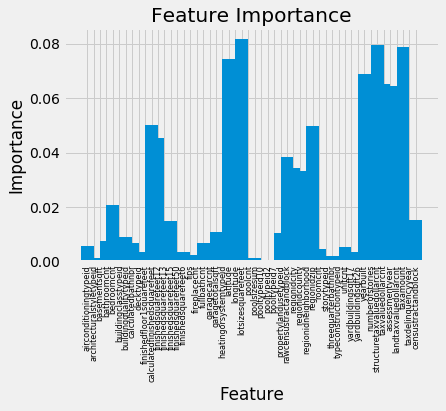

MSE: 0.010661653240242675


In [25]:
# report importances and mse
column_name = list(dat)
predictions = forest.predict(X_test)
MSE = mean_squared_error(predictions,y_test)

importances = list(forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_name, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical',width = 2)
plt.xticks(x_values, column_name, rotation='vertical',fontsize=8)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance');
plt.show()

print('MSE: {}'.format(MSE))

## e) KFold

In [56]:
# KFold, k = 5
data_e = dat[:500:]
rf = RandomForestRegressor(n_estimators = 10,random_state=42)
X = np.array(data_e)
y = data.logerror[:500:]

kf = KFold(n_splits=5)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
MSE = mean_squared_error(predictions,y_test)
print('MSE: {}'.format(MSE))

MSE: 0.012315034963505635


In [61]:
# Run d2 for 100 times
X_train, X_test, y_train, y_test = train_test_split(dat, logerr, test_size=0.30)
for i in range(100):
    forest = RandomForestRegressor(n_estimators = 10,random_state = i)
    ff = forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    MSE = mean_squared_error(pred,y_test)
    print('MSE: {}'.format(MSE))

MSE: 0.01067454521263678
MSE: 0.010556285873614783
MSE: 0.010626445537941325
MSE: 0.010607956448550055
MSE: 0.01064504136851938
MSE: 0.01055244078551665
MSE: 0.010621338971030464
MSE: 0.0106333753622783
MSE: 0.01063961061226757
MSE: 0.010622999656804162
MSE: 0.010617927421001904
MSE: 0.010664411900479212
MSE: 0.010576316361560445
MSE: 0.010609709934935126
MSE: 0.010588078451086074
MSE: 0.01059668316379205
MSE: 0.01060969404515634
MSE: 0.010624413225560623
MSE: 0.01055758491560423
MSE: 0.010654649565840281
MSE: 0.01065902361959131
MSE: 0.010595047516065858
MSE: 0.010637393586304387
MSE: 0.010659686061153233
MSE: 0.010625686308692166
MSE: 0.010648763853718149
MSE: 0.010688148122373621
MSE: 0.010581947146396146
MSE: 0.010599630720277475
MSE: 0.010625873334908628
MSE: 0.010614486955492584
MSE: 0.010591387368584589
MSE: 0.010611934919258216
MSE: 0.010598363149572082
MSE: 0.010596752276538253
MSE: 0.010629497707809046
MSE: 0.01065455914308545
MSE: 0.01064691179841783
MSE: 0.01062714967187483

The MSE did not change too much with each iteration, however, the advantage of cross-validation is it helps with overfitting. In K-Folds Cross Validation, the data is split into k different subsets, and the model is trained on k-1 subsets and the last subset is used as test data. This helps with overfitting and less random findings.